# Libraries

In [1]:
import time
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas.core.api import Series as Series
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import yfinance as yf
import requests
import pytz
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
import warnings as wrn
import os
from enum import Enum
from typing import Tuple
import itertools
import math

# Setting up params

In [2]:
# general_stocks = ['KO', 'PFE', 'WMT', 'PG', 'JNJ', 'DIS', 'PEP', 'MCD', 'T', 'VZ']
# tech_stocks = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META', 'INTC', 'IBM', 'AMD']
# finance_stocks = ['GS', 'BAC', 'WFC', 'USB', 'JPM', 'MA', 'V', 'AXP', 'C', 'BLK']
decentralized_currencies = ['BTC', 'ETH', 'ADA', 'SOL', 'XRP', 'XMR', 'LTC', 'DOT', 'LINK', 'XTZ', 'DOGE']

# general_stocks_names = ['Coca-Cola', 'Pfizer', 'Walmart', 'Procter & Gamble', 'Johnson & Johnson', 'Disney', 'Pepsi', 'McDonalds', 'AT&T', 'Verizon']
# tech_stocks_names = ['Apple', 'Amazon', 'Microsoft', 'Google', 'Nvidia', 'Tesla', 'Meta', 'Intel', 'IBM', 'AMD']
# finance_stocks_names = ['Goldman Sachs', 'Bank of America', 'Wells Fargo', 'US Bancorp', 'JPMorgan Chase', 'Mastercard', 'Visa', 'American Express', 'Citigroup', 'BlackRock']
decentralized_currencies_names = ['Bitcoin', 'Ethereum', 'Cardano', 'Solana', 'Ripple', 'Monero', 'Litecoin', 'Polkadot', 'Chainlink', 'Tezos', 'Dogecoin']

# color_map = {
#     'general': 'deepskyblue',
#     'tech': 'limegreen',
#     'finance': 'darkorchid',
#     'crypto': 'red'
# }

start = '2019-06-30'
end = '2024-07-01'
max_lags = 7

# Functions and Classes
## get_trends_data
gets the trend data using pytrends, given a certain timeframe

In [3]:
def get_trends_data(keyword, 
                    timeframe=datetime.date.today().strftime('%Y-%m-%d') + ' ' + (datetime.date.today() - datetime.timedelta(days = 269)).strftime('%Y-%m-%d'),
                    retries=5, backoff_factor=1.0, verbose=True):
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), )
    pytrends.build_payload(keyword, cat = 0, timeframe = timeframe, geo='')
    
    for i in range(retries):
        try:
            df = pytrends.interest_over_time()
            if df is not None and not df.empty:
                if verbose:
                    print(f"Trend Data for {keyword[0]} at timeframe {timeframe} retrieved successfully.")
                df.reset_index(inplace = True)
                df.rename(columns = {'date': 'Date', keyword[0]: 'Trend'}, inplace = True)
                df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%m/%d/%Y'))
                return df
            else:
                print("No data retrieved or DataFrame is empty.")
                return None
        except Exception as e:
            if "429" in str(e):
                sleep_time = backoff_factor * (2 ** i)
                if verbose:
                    print(f"Rate limit exceeded. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                raise(f"An error occurred: {e}")
    print("Failed to retrieve data after several retries.")
    return None

## get_stock_data
gets the prices of a certain stock in a certain timeframe

In [4]:
# from binance
def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')

def get_binance_historical_data(symbol, interval= '1d', start_date='2019-06-30', end_date='2024-07-01'):
    
    # define basic parameters for call
    base_url = 'https://fapi.binance.com'
    endpoint = '/fapi/v1/klines'
    method = 'GET'
    
    # Set the start time parameter in the params dictionary
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': 1500,
        'startTime': int(datetime.datetime.strptime(start_date, "%Y-%m-%d").timestamp() * 1000), # Start time in milliseconds,
        'endTime': int(datetime.datetime.strptime(end_date, "%Y-%m-%d").timestamp() * 1000) # End time in milliseconds
    }

    # Make initial API call to get candles
    response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)

    candles_data = []

    while len(response.json()) > 0:
        # Append the received candles to the list
        candles_data.extend(response.json())

        # Update the start time for the next API call
        params['startTime'] = candles_data[-1][0] + 1 # last candle open_time + 1ms

        try:
            # Make the next API call
            response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)
        except Exception as e:
            raise Exception(f'{symbol} - {e}')

    
    # Wrap the candles data as a pandas DataFrame
    columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'quote_asset_volume',
               'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    dtype={
    'Date': 'datetime64[ms, Asia/Jerusalem]',
    'Open': 'float64',
    'High': 'float64',
    'Low': 'float64',
    'Close': 'float64',
    'Volume': 'float64',
    'close_time': 'datetime64[ms, Asia/Jerusalem]',
    'quote_asset_volume': 'float64',
    'number_of_trades': 'int64',
    'taker_buy_base_asset_volume': 'float64',
    'taker_buy_quote_asset_volume': 'float64',
    'ignore': 'float64'
    }
    
    df = pd.DataFrame(candles_data, columns=columns)
    df = df.astype(dtype)

    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    return df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

In [5]:
# from yfinance
def get_stock_data(ticker, start, end, verbose = True):
    currTicker = yf.Ticker(ticker)
    tickerDF = currTicker.history(repair = True, start = start, end = end, auto_adjust = False).drop(columns = ['Dividends', 'Stock Splits', 'Repaired?']).reset_index()
    if verbose:
        print(f"Stock Data for {ticker} retrieved successfully.")
    tickerDF['Date'] = pd.to_datetime(tickerDF['Date'].dt.strftime('%m/%d/%Y'))
    return tickerDF

## trend_corr
gets the data of the trends and prices of the stock given to it in a certain timeframe and calculates the correlation between the log_returns and the trends delayed by certain delay

In [6]:
def trend_corr(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        if stock in decentralized_currencies:
            p = get_stock_data(f'{stock}-USD', start = start, end = end)
        else:
            p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    for i in range(1, 8):
        full_data[f'Delay_{i}'] = full_data['Trend'].shift(i)

    rho = full_data.corr()
    rho_c = rho['Close'][f'Delay_{delay}']
    return rho_c, full_data

## plot_stock_data
gets the data of the trends and the prices of the stock given to it in a certain timeframe and plots its close and its delayed trend

In [7]:
def plot_stock_data(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7, download = False):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    full_data[f'Delay_{delay}'] = full_data.Trend.shift(7)

    # Determine the color based on the stock category
    if stock in general_stocks:
        color = color_map['general']
        name = general_stocks_names[general_stocks.index(stock)]
    elif stock in tech_stocks:
        color = color_map['tech']
        name = tech_stocks_names[tech_stocks.index(stock)]
    elif stock in finance_stocks:
        color = color_map['finance']
        name = finance_stocks_names[finance_stocks.index(stock)]
    else:
        color = color_map['crypto']
        name = decentralized_currencies_names[decentralized_currencies.index(stock)]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Close price
    axes[0].plot(full_data['Date'], full_data['Close'], label = 'Close Price', color = color)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Close Price')
    axes[0].set_title(f'{stock}: Close Price')
    legend = axes[0].legend(loc='upper left')
    legend.get_frame().set_alpha(0.3)

    # Plot 7-days delay trend
    axes[1].plot(full_data['Date'], full_data[f'Delay_{delay}'], label = f'{delay}-Days Delayed Trend', color = 'black')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel(f'{delay}-Days Delayed Trend')
    axes[1].set_title(f'{stock}: {delay}-Days Delayed Trend')
    legend = axes[1].legend(loc='upper right')
    legend.get_frame().set_alpha(0.3)

    fig.suptitle(f'{name} ({stock})', fontsize=20, verticalalignment = 'bottom', fontweight = 'bold')
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.95)
    if download:
        plt.savefig(f"./Plots/{stock}_plot({start} - {end}).png", bbox_inches='tight')
    plt.show()

## time_jump
adds time in days to a given date that was accepted as string, returns as string

In [8]:
# function to find the date in string format after a certain number of days
def time_jump(start, days = 7 * 38):
    return (datetime.datetime.strptime(start, '%Y-%m-%d') + datetime.timedelta(days = days)).strftime('%Y-%m-%d')

## get_breakpoints
calculates the breakpoints needed for the multiple requests of data to make the data as long as possible for us

In [9]:
def get_breakpoints(start, end, days = 7 * 38):
    breakpoints = [start]
    while datetime.datetime.strptime(breakpoints[-1], '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
        temp = time_jump(breakpoints[-1], days)
        if datetime.datetime.strptime(temp, '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
            breakpoints.append(temp)
        else:
            breakpoints.append(end)
    return breakpoints

## connectNnormalizeTrends
gets the data of the trends and prices daily in the whole time frame and in parts, and connects them by estimating an eproximation of their absolute amount of searches

In [10]:
def connectNnormalizeTrends(Dfs, stock):
    # setting up the data for step 1
    if not os.path.exists(f'./Data/glimpse_{stock}_5Y.csv'):
        raise Exception(f'Failed to retrieve Glimpse Data of {stock}.')
    glmpsDf = pd.read_csv(f'./Data/glimpse_{stock}_5Y.csv')
    glmpsDf.rename(columns={'Time (week of)': 'Date', 'Absolute Google Search Volume': 'Absolute_Volume'}, inplace=True)
    glmpsDf['Date'] = pd.to_datetime(glmpsDf['Date'])

    df_concat = pd.concat(Dfs).reset_index(drop = True)
    df_concat['Date'] = pd.to_datetime(df_concat['Date'])

    # calculating the mean trend for each week and merging it into glmpsDf
    df_concat['MeanTrend'] = df_concat['Trend'].rolling(window=7, min_periods=1).mean().shift(-6)
    glmpsDf = pd.merge(glmpsDf, df_concat, on='Date', how='left').drop(columns = ['Trend'])

    # setting up the data for step 2
    glmpsDf.rename(columns={'Date': 'Date_Week'}, inplace=True)
    df_concat = df_concat.drop(columns = ['MeanTrend'])
    df_concat['Date_Week'] = (df_concat['Date'] - pd.to_timedelta((df_concat['Date'].dt.weekday + 1) % 7, unit='d')).dt.strftime('%Y-%m-%d')
    df_concat['Date_Week'] = pd.to_datetime(df_concat['Date_Week'])

    # calculating the ratio and search volume for each week
    df_concat = pd.merge(df_concat, glmpsDf[['Date_Week', 'MeanTrend', 'Absolute_Volume']], on='Date_Week', how='left')
    df_concat['Ratio'] = df_concat['Trend'] / (df_concat['MeanTrend'] * 7)
    df_concat['Search_Volume'] = df_concat['Ratio'] * df_concat['Absolute_Volume']

    # adding to df_concat the check ratio to check validity of the data
    df_concat['check_ratio'] = df_concat['Search_Volume'] / df_concat['Trend']

    # renormalizing the data
    df_concat['Normalized_Searches'] = ((df_concat['Search_Volume'] - df_concat['Search_Volume'].min()) / (df_concat['Search_Volume'].max() - df_concat['Search_Volume'].min())) * 100

    # cleaning out unnecessary columns
    df_concat = df_concat.drop(columns = ['Trend', 'Date_Week', 'MeanTrend', 'Absolute_Volume', 'Ratio'])

    df_concat['Date'] = df_concat['Date'].dt.strftime('%Y-%m-%d')

    return df_concat

## getNormalizedData
gets the data normalized, and performs validity checks (optional)

In [11]:
def getNormalizedData(stock, ticker, start = '2019-06-23', end = '2024-06-01', weeks = 38, do_double = True, verbose = False):
    if weeks > 38:
        wrn.warn('The maximum number of weeks is 38. \nThe number of weeks will be set to 38.', category=Warning)
        weeks = 38
    if do_double & (weeks % 2 != 0):
        wrn.warn('The number of weeks must be even to use the double method. \nThe number of weeks will be rounded down to the nearest even number.', category=Warning)
        weeks -= 1
    breakpoints = get_breakpoints(start, end, days = 7 * weeks)
    if do_double:
        breakpoints2 = get_breakpoints(start, end, days = 7 * weeks / 2)
        breakpoints2 = [x for x in breakpoints2 if x not in breakpoints[1:-1]]
    
    # initializing the list to store the dataframes
    Dfs = []

    # extracting the data for each time period
    for i in range(len(breakpoints) - 1):
        startTemp = breakpoints[i]
        endTemp = time_jump(breakpoints[i + 1], days=-1)
        # checking if the data is already extracted
        if not os.path.exists(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv"):
            # extracting the data
            t = get_trends_data([stock], timeframe = f"{startTemp} {endTemp}", verbose = verbose).drop(columns = ['isPartial'])
            if t is None:
                raise Exception(f'Failed to retrieve Trend Data of {stock}.')
            t.to_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv")
        else:
            t = pd.read_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv").drop(columns = ['Unnamed: 0'])

        Dfs.append(t)

    df_concat = connectNnormalizeTrends(Dfs, stock)

    if do_double:
        # initializing the list to store the dataframes
        Dfs2 = []

        # extracting the data for each time period
        for i in range(len(breakpoints2) - 1):
            startTemp = breakpoints2[i]
            endTemp = time_jump(breakpoints2[i + 1], days=-1)
            # checking if the data is already extracted
            if not os.path.exists(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv"):
                # extracting the data
                t = get_trends_data([stock], timeframe = f"{startTemp} {endTemp}", verbose = verbose).drop(columns = ['isPartial'])
                if t is None:
                    raise Exception(f'Failed to retrieve Trend Data of {stock}.')
                t.to_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv")
            else:
                t = pd.read_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv").drop(columns = ['Unnamed: 0'])

            Dfs2.append(t)
        
        df_concat2 = connectNnormalizeTrends(Dfs2, stock)
    
        df_concat["Normalized_Searches"] = (df_concat["Normalized_Searches"] + df_concat2["Normalized_Searches"]) / 2
    
    if not os.path.exists(f"./Data/{stock}_Prices({start}-{end}).csv"):
        stockData = get_binance_historical_data(f'{ticker}USDT', start_date=start, end_date=end)
        stockData.to_csv(f"./Data/{stock}_Prices({start}-{end}).csv")
    else:
        stockData = pd.read_csv(f"./Data/{stock}_Prices({start}-{end}).csv").drop(columns = ['Unnamed: 0'])

    df_concat[df_concat.Normalized_Searches == 0] = 0.1

    df_concat['log_searches'] = np.log(df_concat.Normalized_Searches / df_concat.Normalized_Searches.shift(1))
    stockData['log_returns'] = np.log(stockData.Close / stockData.Close.shift(1))

    try:
        df_concat['Date'] = df_concat['Date'].dt.strftime('%Y-%m-%d')
    except:
        pass
    try:
        stockData['Date'] = stockData['Date'].dt.strftime('%Y-%m-%d')
    except:
        pass

    finalDf = pd.merge(stockData, df_concat, on='Date', how='left').dropna()

    if verbose:
        # data normalization validity check
        top = 0
        bottom = 0
        for i in range(len(Dfs)):
            top += Dfs[i].shape[0]
            print(f'period {i + 1}:\n=========\nmean: {df_concat.iloc[bottom:top]['check_ratio'].mean():.4f}\nsd: {df_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n\nmean/sd: {df_concat.iloc[bottom:top]['check_ratio'].mean()/df_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n')
            bottom += Dfs[i].shape[0]

        if do_double:
            top = 0
            bottom = 0
            for i in range(len(Dfs2)):
                top += Dfs2[i].shape[0]
                print(f'period {i + len(Dfs) + 1}:\n=========\nmean: {df_concat.iloc[bottom:top]['check_ratio'].mean():.4f}\nsd: {df_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n\nmean/sd: {df_concat.iloc[bottom:top]['check_ratio'].mean()/df_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n')
                bottom += Dfs2[i].shape[0]
    return finalDf

## evaluate_strategy
prints and returns the evaluation of the strategy

In [12]:
def calc_total_return(portfolio_values: pd.Series):
    return (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1.0

def calc_annualized_return(portfolio_values):
    portfolio_trading_years = portfolio_values.shape[0] / 365
    return (portfolio_values.iloc[-1] / portfolio_values.iloc[0])**(1/portfolio_trading_years) - 1.0

def calc_annualized_sharpe(portfolio_values: pd.Series, rf: float=0.0): # rf = risk-free rate
    annualized_return = calc_annualized_return(portfolio_values)
    annualized_std = portfolio_values.pct_change().std() * np.sqrt(365)
    if annualized_std is None or annualized_std == 0:
        return 0
    return (annualized_return - rf) / annualized_std

def calc_downside_deviation(portfolio_values):
    porfolio_returns = portfolio_values.pct_change().dropna()
    return porfolio_returns[porfolio_returns < 0].std()

def calc_sortino(portfolio_values, rf=0.0): # rf = risk-free rate
    down_deviation = calc_downside_deviation(portfolio_values) * np.sqrt(365)
    annualized_return = calc_annualized_return(portfolio_values)
    if down_deviation is None or down_deviation == 0:
        return 0
    return (annualized_return - rf) / down_deviation

def calc_max_drawdown(portfolio_values):
    cumulative_max = portfolio_values.cummax()
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    return drawdown.max()

def calc_calmar(portfolio_values):
    max_drawdown = calc_max_drawdown(portfolio_values)
    annualized_return = calc_annualized_return(portfolio_values)
    return annualized_return / max_drawdown

def evaluate_strategy(df, strat_name, rf: float=0.0, returns = True, verbose = True):
    
    df['Date'] = pd.to_datetime(df['Date'])
    first_date = df['Date'].iloc[0]
    df_rest = df[df['Date'] != first_date].groupby('Date').last().reset_index()

    df = pd.concat([df[df['Date'] == first_date].head(1), df_rest]).reset_index(drop = True)
    df = df.sort_values(by = 'Date').reset_index(drop = True)

    total_return = calc_total_return(df['portfolio_value'])
    annualized_return = calc_annualized_return(df['portfolio_value'])
    annualized_sharpe = calc_annualized_sharpe(df['portfolio_value'], rf=rf)
    sortino_ratio = calc_sortino(df['portfolio_value'], rf=rf)
    max_drawdown = calc_max_drawdown(df['portfolio_value'])
    calmar_ratio = calc_calmar(df['portfolio_value'])

    if verbose:    
        trString = f"{total_return:.2%}"
        asString = f"{annualized_return:.2f}"
        mdString = f"{max_drawdown:.2%}"
        print(f"Results for {strat_name}:")
        print(f"  Total Return:            {trString:8s}  Annualized Return: {annualized_return:.2%}")
        print(f"  Annualized Sharpe Ratio: {asString:8s}  Sortino Ratio:     {sortino_ratio:.2f}")
        print(f"  Max Drawdown:            {mdString:8s}  Calmar Ratio:      {calmar_ratio:.2f}")

    if returns:
        return total_return, annualized_return, annualized_sharpe, sortino_ratio, max_drawdown, calmar_ratio


## Connecting the dataframes
so they could be interpeted as one complete investment plan

In [13]:
def dfConnect(DFs: list) -> pd.DataFrame:
    combinedDF = pd.concat(DFs).reset_index(drop = True, inplace = False)
    combinedDF['TempDate'] = pd.to_datetime(combinedDF['Date'])
    combinedDF = combinedDF.sort_values(by = 'TempDate').reset_index(drop = True, inplace = False)
    try:
        combinedDF = combinedDF.drop(columns = ['TempDate', 'index'])
    except:
        combinedDF = combinedDF.drop(columns = ['TempDate'])
    return combinedDF

## Strategy Class

In [14]:
# Enums
class ActionType(Enum):
    BUY = 1
    SELL = -1
    DONOTHING = 0

# our strategy class
class Strategy():
    def __init__(self, bb_window: int, rsi_window: int, 
                 bb_window_min: int=None, bb_buy_threshold: float=0.5, bb_sell_threshold: float=0.5, rsi_window_min: int=None, rsi_limits: Tuple[float,float]=[30.0, 70.0], sell_all: bool=False, qty_scale: float=0.1,
                 commission_type: object="scalar", slippage_factor=np.inf) -> None:
        self.bb_window = bb_window
        self.rsi_window = rsi_window
        if bb_window_min is None:
            bb_window_min = bb_window
        else:
            if bb_window_min > bb_window:
                raise ValueError("bb_window_min should be less than or equal to bb_window")
            if bb_window_min <= 0:
                raise ValueError("bb_window_min should be a value greater than 0")
            self.bb_window_min = bb_window_min
        if bb_buy_threshold <= 0 or bb_sell_threshold <= 0:
            raise ValueError("bb_buy_threshold and bb_sell_threshold should be values greater than 0")
        self.bb_buy_threshold = bb_buy_threshold
        self.bb_sell_threshold = bb_sell_threshold
        if rsi_window_min is None:
            rsi_window_min = rsi_window
        else:
            if rsi_window_min > rsi_window:
                raise ValueError("rsi_window_min should be less than or equal to rsi_window")
            if rsi_window_min <= 0:
                raise ValueError("rsi_window_min should be a value greater than 0")
            self.rsi_window_min = rsi_window_min
        if rsi_limits[0] <= 0 or rsi_limits[1] > 100 or rsi_limits[0] >= rsi_limits[1]:
            raise ValueError("rsi_limit should be a tuple of two values between 0 and 100 where the first value is less than the second")
        self.rsi_limits = rsi_limits
        if commission_type not in ["scalar", "precentage"]:
            raise ValueError("commision_type should be either 'scalar' or 'precentage'")
        self.commission_type = commission_type
        self.sell_all = sell_all
        self.slippage_factor = slippage_factor
        if qty_scale <= 0:
            raise ValueError("qty_scale should be a value greater than 0")
        self.qty_scale = qty_scale

    def calc_signal(self, data: pd.DataFrame) -> None:
        norm_search = data['Normalized_Searches_delayed']
        close = data.Close.shift(1)

        # MA of search volume as threshold for Bollinger Bands
        norm_search_MA = norm_search.rolling(window=self.bb_window, min_periods=self.bb_window_min).mean()
        norm_search_sd = norm_search.rolling(window=self.bb_window, min_periods=self.bb_window_min).std()
        norm_search_sd = norm_search_sd.fillna(0)
        upper_band = norm_search_MA + self.bb_buy_threshold * norm_search_sd
        lower_band = norm_search_MA - self.bb_sell_threshold * norm_search_sd

        data['norm_search_MA_upper_band'] = upper_band
        data['norm_search_MA_lower_band'] = lower_band

        # RSI of close price as threshold limiting the Bollinger Bands signal
        delta = close.diff()
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)
        avg_gain = gains.rolling(window=self.rsi_window, min_periods=self.rsi_window_min).mean()
        avg_loss = losses.rolling(window=self.rsi_window, min_periods=self.rsi_window_min).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        data['strategy'] = 0
        data.loc[(norm_search < lower_band) & (rsi < self.rsi_limits[0]), 'strategy'] = -1 # Sell signal
        data.loc[(norm_search > upper_band) & (rsi > self.rsi_limits[1]), 'strategy'] = 1 # Buy signal

    def calc_realistic_price(self, row: pd.Series, action: ActionType) -> float:
        slippage_rate = ((row['Close'] - row['Open']) / row['Open']) / self.slippage_factor
        slippage_price = row['Open'] + row['Open'] * slippage_rate

        if action == ActionType.BUY:
            return max(slippage_price, row['Open'])
        elif action == ActionType.SELL:
            return min(slippage_price, row['Open'])
        else:
            return slippage_price

# comparison strategy class
class BuyAndHoldStrategy():
    def __init__(self, sell_all: bool=False, qty_scale: float=1.0,
                 commission_type: object="scalar", slippage_factor=np.inf) -> None:
        if commission_type not in ["scalar", "precentage"]:
            raise ValueError("commision_type should be either 'scalar' or 'precentage'")
        self.commission_type = commission_type
        self.sell_all = sell_all
        self.slippage_factor = slippage_factor
        if qty_scale <= 0:
            raise ValueError("qty_scale should be a value greater than 0")
        self.qty_scale = qty_scale
    
    def calc_signal(self, data: DataFrame) -> None:
        data['strategy'] = 0 # Do nothing
        data.iloc[0, data.columns.get_loc('strategy')] = 1 # Buy signal
        data.iloc[-1, data.columns.get_loc('strategy')] = -1 # Sell signal

    def calc_realistic_price(self, row: Series, action: ActionType) -> float:
        slippage_rate = ((row['Close'] - row['Open']) / row['Open']) / self.slippage_factor
        slippage_price = row['Open'] + row['Open'] * slippage_rate

        if action == ActionType.BUY:
            return max(slippage_price, row['Open'])
        elif action == ActionType.SELL:
            return min(slippage_price, row['Open'])
        else:
            return slippage_price

## backtest
backtesting function that can be applied on different strategies

In [15]:
def backtest(DFs: list, strategy: Strategy, starting_balance: float, include: list, commission: float=0.0, hoddle: bool=False) -> pd.DataFrame:
    for i in range(len(DFs)):
        strategy.calc_signal(DFs[i])
        DFs[i]['coin'] = decentralized_currencies_names[include[i]]
        DFs[i].reset_index(drop=True)

    # memory dataframe
    mem = pd.DataFrame({'coin': [decentralized_currencies_names[include[i]] for i in range(len(DFs))], 
                        'qty': 0.0,
                        'price': 0.0})

    data = dfConnect(DFs)
    data['qty'] = 0.0
    data['balance'] = 0.0
    data['coins_value'] = 0.0

    for i, row in data.iterrows():
        # Get the current balance and qty before the action
        curr_qty = mem.loc[mem.coin == data.loc[i, 'coin'], 'qty'].values[0]
        prev_price = mem.loc[mem.coin == data.loc[i, 'coin'], 'price'].values[0]
        new_price = strategy.calc_realistic_price(row, ActionType.BUY if row['strategy'] == 1 else ActionType.DONOTHING if ((row['strategy'] != -1) | (row['Date'] == data.Date.iloc[-1])) else ActionType.SELL)
        mem.loc[mem.coin == data.loc[i, 'coin'], 'price'] = new_price
        curr_balance = data.loc[i - 1, 'balance'] + (new_price - prev_price) * curr_qty if i > 0 else starting_balance
        if curr_balance < 0:
            new_price = strategy.calc_realistic_price(row, ActionType.SELL)
            curr_balance = data.loc[i - 1, 'balance'] + (new_price - prev_price) * curr_qty if i > 0 else starting_balance
        curr_coin_value = data.loc[i - 1, 'coins_value'] + (new_price - prev_price) * curr_qty if i > 0 else 0.0

        # Sell signal when strategy says so or at the end of trade and holding any stock
        if (curr_qty > 0) & ((row['Date'] == data.Date.iloc[-1]) | (row['strategy'] == -1) | (curr_balance < 0)):
            if hoddle:
                sell_qty = curr_qty
            else:
                sell_qty = curr_qty if (strategy.sell_all | (row['Date'] == data.Date.iloc[-1])) else min((row['norm_search_MA_lower_band'] / row['Normalized_Searches_delayed'] - 1) * strategy.qty_scale, curr_qty)
            data.loc[i, 'balance'] = curr_balance + (new_price * sell_qty - commission if strategy.commission_type == "scalar" else new_price * sell_qty * (1 - commission))
            data.loc[i, 'qty'] = 0.0 if (strategy.sell_all | (row['Date'] == data.Date.iloc[-1])) else curr_qty - sell_qty
            mem.loc[mem.coin == data.loc[i, 'coin'], 'qty'] = 0.0 if (strategy.sell_all | (row['Date'] == data.Date.iloc[-1])) else curr_qty - sell_qty
            data.loc[i, 'coins_value'] = curr_coin_value - ((new_price - prev_price) * sell_qty)

        # Buy signal when strategy says so as long not in the end of trade data and not holding any stock
        elif (row['Date'] != data.Date.iloc[-1]) & (data.loc[i, 'strategy'] == 1) & (curr_balance > 0):
            if hoddle:
                buy_qty = (starting_balance / len(DFs)) / new_price
            else:
                buy_qty = min((row['Normalized_Searches_delayed'] / row['norm_search_MA_upper_band'] - 1) * strategy.qty_scale, (curr_balance - commission) / new_price if strategy.commission_type == "scalar" else curr_balance / (new_price * (1 + commission)))
            data.loc[i, 'balance'] = curr_balance - (new_price * buy_qty + commission if strategy.commission_type == "scalar" else new_price * buy_qty * (1 + commission))
            data.loc[i, 'qty'] = curr_qty + buy_qty
            mem.loc[mem.coin == data.loc[i, 'coin'], 'qty'] = curr_qty + buy_qty
            data.loc[i, 'coins_value'] = curr_coin_value + ((new_price - prev_price) * buy_qty)

        # Do nothing
        else:
            data.loc[i, 'balance'] = curr_balance
            data.loc[i, 'qty'] = curr_qty
            data.loc[i, 'coins_value'] = curr_coin_value
        
    data['portfolio_value'] = data['balance'] + data['coins_value']

    return data

## Log functions

In [16]:
def readTrainTestLog(file = './log.txt'):
    total_retruns, annualized_returns, annualized_sharpes, sortino_ratios, max_drawdowns, calmar_ratios = [], [], [], [], [], []
    first = True
    with open(file, 'r') as f:
        for line in f:
            if first:
                first = False
                continue
            total_retruns.append(float(line.split()[1][-2]) / 100)
            annualized_returns.append(float(line.split()[3][-2]) / 100)
            annualized_sharpes.append(float(line.split()[5][-1]))
            sortino_ratios.append(float(line.split()[7][-1]))
            max_drawdowns.append(float(line.split()[9][-2]) / 100)
            calmar_ratios.append(float(line.split()[11][-1]))
    return total_retruns, annualized_returns, annualized_sharpes, sortino_ratios, max_drawdowns, calmar_ratios

def writeTrainTestLog(total_return, annualized_return, annualized_sharpe, sortino_ratio, max_drawdown, calmar_ratio, filePath = './log.txt'):
    if not os.path.exists(filePath):
        with open(filePath, 'a') as file:
            file.write('total_return annualized_return annualized_sharpe sortino_ratio max_drawdown calmar_ratio\n')
    with open(filePath, 'a') as file:
        file.write(f'tr {total_return:.2%} ar {annualized_return:.2%} as {annualized_sharpe:.2f} sr {sortino_ratio:.2f} md {max_drawdown:.2%} cr {calmar_ratio:.2f}\n')

# Granger Causality Tests

In [17]:
def do_granger(DFs: list, max_lags: int = 7, verbose: bool = True) -> Tuple[list, list]:
    wrn.filterwarnings('ignore', category=UserWarning)
    wrn.filterwarnings('ignore', category=FutureWarning)

    lags = []
    p_values = []

    for i in range(len(DFs)):
        try:
            cause = grangercausalitytests(DFs[i][['log_returns', 'log_searches']], 
                                          maxlag = max_lags, 
                                          verbose = False)
        except Exception as e:
            raise Exception(f'Failed to perform Granger Causality Test on {decentralized_currencies_names[i]}: {e}')

        min_p_value = float('inf')
        min_p_lag = None

        for lag, result in cause.items():
            p_value = result[0]['ssr_ftest'][1]
            if p_value < min_p_value:
                min_p_value = p_value
                min_p_lag = lag

        lags.append(min_p_lag)
        p_values.append(min_p_value)

        if verbose:
            print(f'{decentralized_currencies_names[i]}: {min_p_lag} lags, p-value = {min_p_value:.4f}')
    
    return lags, p_values

# Collecting & Connecting The Data

In [18]:
wrn.filterwarnings('ignore', category=UserWarning)
wrn.filterwarnings('ignore', category=FutureWarning)

coinsDFs = []

for i in range(len(decentralized_currencies)):
    coinsDFs.append(getNormalizedData(decentralized_currencies_names[i], decentralized_currencies[i], 
                                      start = start, end = end, 
                                      do_double = True))

# Backtesting
## description
### Data Split
* 4 years train
* 1 year test
### hyper-parameters:
* bb_window: size of the window of MA of the normalized searches and the bollinger bands on that MA
* bb_window_min: minimum size of the window of MA of the normalized searches and the bollinger bands on that MA
* bb_buy_threshold: how many sds should be added to the MA for the upper band
* bb_sell_threshold: how many sds should be subtracted from the MA for the lower band
* rsi_window: size of the window of the RSI on the Close
* rsi_window_min: minimum size of the window of RSI on the Close
* rsi_limits: how sensitive the rsi is, 
    - the higher the lower value (the first value of rsi_limits) the less the RSI blocks a BUY signal
    - the lower the higher value (the second value of rsi_limits) the less the RSI blocks a SELL signal
* sell_all: a boolian value that indicates whether the strategy says to sell all of the quantity of the asset when it gives a SELL signal or the strategy says to sell some relative amount of the quantity when it gives a SELL signal
* qty_scale: represents the scale of the quantity that is calculated by the strategy
### additional parameters:
* starting_balance: the starting balance
* commission: the commission for every market dealing
* commission_type: whether the commission is a set amount or some precentage from the price
* slippage_factor: how much slippage exists in the market 
## Defining Hyper-Parameters

In [19]:
balance = 10000

# hyperparameters
bb_window = [10, 14, 18]
rsi_window = [21, 28, 35]
bb_buy_threshold = [0.1, 0.5, 1, 2]
bb_sell_threshold = [0.1, 0.5, 1, 2]
rsi_limits = [[20.0, 80.0], [30.0, 70.0]]
qty_scale = [0.7, 1.2, 1.6]
max_p_value = [0.1, 0.15, 0.2]

# perm parameters
bb_window_min = 1
rsi_window_min = 1
sell_all = True
commission = 0.0001
commission_type = "precentage"
slippage_factor = 1.0
max_lags = 7
cutoff = '2023-07-01'

# permute the hyperparameters
params = list(itertools.product(bb_window, rsi_window, bb_buy_threshold, bb_sell_threshold, rsi_limits, qty_scale, max_p_value))

amntOparams = len(params)

fill_stages = [' ', '\u2591', '\u2592', '\u2593', '\u2588']

## Active Backtesting

In [20]:
wrn.filterwarnings('ignore')

start_time = time.time()
prev_time = start_time

if os.path.exists('./trainLog.txt'):
    train_total_returns, train_annualized_returns, train_annualized_sharpes, train_sortino_ratios, train_max_drawdowns, train_calmar_ratios = readTrainTestLog('./trainLog.txt')
    test_total_returns, test_annualized_returns, test_annualized_sharpes, test_sortino_ratios, test_max_drawdowns, test_calmar_ratios = readTrainTestLog('./testLog.txt')
else:
    train_total_returns, train_annualized_returns, train_annualized_sharpes, train_sortino_ratios, train_max_drawdowns, train_calmar_ratios = [], [], [], [], [], []
    test_total_returns, test_annualized_returns, test_annualized_sharpes, test_sortino_ratios, test_max_drawdowns, test_calmar_ratios = [], [], [], [], [], []

starting_pos = len(train_total_returns)

runTimeList = []

for i, param in enumerate(params[starting_pos:]):
    bb_window, rsi_window, bb_buy_threshold, bb_sell_threshold, rsi_limits, qty_scale, max_p_value = param

    coinsTrainDfs = []
    coinsTestDfs = []

    for j, df in enumerate(coinsDFs):
        df['temp_date'] = pd.to_datetime(df['Date'])
        coinsTrainDfs.append(df[df['temp_date'] <= pd.to_datetime(cutoff)])
        coinsTestDfs.append(df[df['temp_date'] > pd.to_datetime(cutoff)])
        df.drop(columns = ['temp_date'], inplace = True)

    lags, p_values = do_granger(coinsTrainDfs.copy(), max_lags=max_lags, verbose=False)

    for j in range(len(coinsTrainDfs)):
        coinsTrainDfs[j]['Normalized_Searches_delayed'] = coinsTrainDfs[j]['Normalized_Searches'].shift(lags[j])
        coinsTrainDfs[j].dropna(inplace = True)
        coinsTestDfs[j]['Normalized_Searches_delayed'] = coinsTestDfs[j]['Normalized_Searches'].shift(lags[j])
        coinsTestDfs[j].dropna(inplace = True)

    include = [j for j, r in enumerate(np.array(p_values) < max_p_value)if r]
    coinsIncluded = [decentralized_currencies_names[j] for j in include]
    coinsTrainDfs = [coinsTrainDfs[j] for j in include]
    coinsTestDfs = [coinsTestDfs[j] for j in include]

    strat = Strategy(bb_window=bb_window, rsi_window=rsi_window, bb_window_min=bb_window_min, bb_buy_threshold=bb_buy_threshold, bb_sell_threshold=bb_sell_threshold, rsi_window_min=rsi_window_min, rsi_limits=rsi_limits, sell_all=sell_all, qty_scale=qty_scale, commission_type=commission_type, slippage_factor=slippage_factor)
    stratTrainDf = backtest(coinsTrainDfs.copy(), strat, balance, include, commission)
    stratTrainDf.dropna(inplace = True)
    stratTestDf = backtest(coinsTestDfs.copy(), strat, balance, include, commission)
    stratTestDf.dropna(inplace = True)

    hyperParamsLine1 = f'  Window:         {bb_window}  Upper Band Threshold (Buy Threshold):       {bb_buy_threshold}'
    hyperParamsLine2 = f'                               Lower Band Sell Threshold (Sell Threshold): {bb_sell_threshold}'
    hyperParamsLine3 = f'  window:         {rsi_window}  Limits:                               {rsi_limits}'
    hyperParamsLine4 = f'  Quantity scale: {qty_scale} max p-value:                           {max_p_value}'
    
    print(f'Strategy Hyper-Parameters:\n{'=' * len(hyperParamsLine1)}\n Bollinger Bands:\n{hyperParamsLine1}\n{hyperParamsLine2}\n Relative Strength Index (RSI):\n{hyperParamsLine3}\n Others:\n{hyperParamsLine3}\n{'=' * len(hyperParamsLine4)}\n')

    train_total_return, train_annualized_return, train_annualized_sharpe, train_sortino_ratio, train_max_drawdown, train_calmar_ratio = evaluate_strategy(stratTrainDf.copy(), 'Train', rf=0.052)
    print()
    test_total_return, test_annualized_return, test_annualized_sharpe, test_sortino_ratio, test_max_drawdown, test_calmar_ratio = evaluate_strategy(stratTestDf.copy(), 'Test', rf=0.052)
    print()

    train_total_returns.append(train_total_return)
    train_annualized_returns.append(train_annualized_return)
    train_annualized_sharpes.append(train_annualized_sharpe)
    train_sortino_ratios.append(train_sortino_ratio)
    train_max_drawdowns.append(train_max_drawdown)
    train_calmar_ratios.append(train_calmar_ratio)

    test_total_returns.append(test_total_return)
    test_annualized_returns.append(test_annualized_return)
    test_annualized_sharpes.append(test_annualized_sharpe)
    test_sortino_ratios.append(test_sortino_ratio)
    test_max_drawdowns.append(test_max_drawdown)
    test_calmar_ratios.append(test_calmar_ratio)

    writeTrainTestLog(train_total_return, train_annualized_return, train_annualized_sharpe, train_sortino_ratio, train_max_drawdown, train_calmar_ratio, filePath = './trainLog.txt')
    writeTrainTestLog(test_total_return, test_annualized_return, test_annualized_sharpe, test_sortino_ratio, test_max_drawdown, test_calmar_ratio, filePath = './testLog.txt')

    print(f'Coins Included ({len(coinsIncluded)}):\n============================================')
    for j in range(len(coinsIncluded)):
        print(f'  \u2022 {coinsIncluded[j]:10s}', end = '\n' if (j + 1) % 3 == 0 else '  ')

    if len(coinsIncluded) % 3 != 0:
        print()

    curr_time = time.time()
    elapsed = round(curr_time - start_time, 2)
    if elapsed > 60:
        elapsed_mins = elapsed // 60
        elapsed_secs = elapsed % 60
        if elapsed_mins > 60:
            elapsed_hours = elapsed_mins // 60
            elapsed_mins = elapsed_mins % 60
            time_elapsed = f'{elapsed_hours:.0f}h {elapsed_mins:.0f}m {elapsed_secs:.2f}s'
        else:
            time_elapsed = f'{elapsed_mins:.0f}m {elapsed_secs:.2f}s'
    else:
        time_elapsed = f'{elapsed:.2f}s'
    from_last = round(curr_time - prev_time, 2)

    runTimeList.append(from_last)

    avgRunTime = np.array(runTimeList).mean().round(2)

    estimated = round(avgRunTime * (amntOparams - i - 1 - starting_pos), 2)

    if estimated > 60:
        estimated_mins = estimated // 60
        estimated_secs = estimated % 60
        if estimated_mins > 60:
            estimated_hours = estimated_mins // 60
            estimated_mins = estimated_mins % 60
            estimatedTime = f'{estimated_hours:.0f}h {estimated_mins:.0f}m {estimated_secs:.2f}s'
        else:
            estimatedTime = f'{estimated_mins:.0f}m {estimated_secs:.2f}s'
    else:
        estimatedTime = f'{estimated:.2f}s'

    estimatedFinishTime = time.strftime('%H:%M:%S', time.localtime(curr_time + estimated))

    print(f'\nTime elapsed: {time_elapsed}, Time from previous run: {from_last}s\nAverage run time: {avgRunTime}s, Estimated run time left: {estimatedTime}\nEstimated time to finish: {estimatedFinishTime}\n{i + starting_pos + 1}/{amntOparams} = {((i + starting_pos + 1) / amntOparams):.2%}\n[{fill_stages[4] * (math.floor(((i + starting_pos + 1) / amntOparams) * 100) // 4)}{fill_stages[(math.ceil(((i + starting_pos + 1) / amntOparams) * 100) - 1) % 4]}{' ' * (25 - math.ceil(((i + starting_pos + 1) / amntOparams) * 100) // 4)}]\n')
    prev_time = curr_time

bb_windows, rsi_windows, bb_buy_thresholds, bb_sell_thresholds, rsi_limitss, qty_scales, max_p_values = zip(*params)
trainResultsDf = pd.DataFrame({'total_return': train_total_returns, 'annualized_return': train_annualized_returns, 'annualized_sharpe': train_annualized_sharpes, 'sortino_ratio': train_sortino_ratios, 'max_drawdown': train_max_drawdowns, 'calmar_ratio': train_calmar_ratios, 'bb_window': bb_windows, 'rsi_window': rsi_windows, 'bb_buy_threshold': bb_buy_thresholds, 'bb_sell_threshold': bb_sell_thresholds, 'rsi_limits': rsi_limitss, 'qty_scale': qty_scales, 'max_p_value': max_p_values})
testResultsDf = pd.DataFrame({'total_return': test_total_returns, 'annualized_return': test_annualized_returns, 'annualized_sharpe': test_annualized_sharpes, 'sortino_ratio': test_sortino_ratios, 'max_drawdown': test_max_drawdowns, 'calmar_ratio': test_calmar_ratios, 'bb_window': bb_windows, 'rsi_window': rsi_windows, 'bb_buy_threshold': bb_buy_thresholds, 'bb_sell_threshold': bb_sell_thresholds, 'rsi_limits': rsi_limitss, 'qty_scale': qty_scales, 'max_p_value': max_p_values})
overallResultsDf = pd.DataFrame({'train_total_return': train_total_returns, 'test_total_return': test_total_returns, 'train_annualized_return': train_annualized_returns, 'test_annualized_return': test_annualized_returns, 'train_annualized_sharpe': train_annualized_sharpes, 'test_annualized_sharpe': test_annualized_sharpes, 'train_sortino_ratio': train_sortino_ratios, 'test_sortino_ratio': test_sortino_ratios, 'train_max_drawdown': train_max_drawdowns, 'test_max_drawdown': test_max_drawdowns, 'train_calmar_ratio': train_calmar_ratios, 'test_calmar_ratio': test_calmar_ratios, 'bb_window': bb_windows, 'rsi_window': rsi_windows, 'bb_buy_threshold': bb_buy_thresholds, 'bb_sell_threshold': bb_sell_thresholds, 'rsi_limits': rsi_limitss, 'qty_scale': qty_scales, 'max_p_value': max_p_values})

Strategy hyperparameters:
  bb_window:   10             rsi_window: 21     bb_threshold: [0.1, 0.1]
  rsi_limits:  [20.0, 80.0]   qty_scale:  0.7    max_p_value:  0.1

Results for Train:
  Total Return:            -365.32%  Annualized Return: nan%
  Annualized Sharpe Ratio: nan       Sortino Ratio:     nan
  Max Drawdown:            154.03%   Calmar Ratio:      nan

Results for Test:
  Total Return:            -0.22%    Annualized Return: -0.22%
  Annualized Sharpe Ratio: -0.00     Sortino Ratio:     -0.00
  Max Drawdown:            120.73%   Calmar Ratio:      -0.00

Coins included (6):
  • Ethereum      • Cardano       • Litecoin  
  • Polkadot      • Chainlink     • Dogecoin  

Time elapsed: 10.50s, Time from previous run: 10.5s
Average run time: 10.5s, Estimated run time left: 7h 33m 25.50s
Estimated time to finish: 21:00:07
1/2592 = 0.04%
[                          ]

Strategy hyperparameters:
  bb_window:   10             rsi_window: 21     bb_threshold: [0.1, 0.1]
  rsi_limits: 

KeyboardInterrupt: 

## Backtesting End & it's Results

In [ ]:
bestIdx = np.argmax(train_calmar_ratios)
bb_window, rsi_window, bb_buy_threshold, bb_sell_threshold, rsi_limits, qty_scale, max_p_value = params[bestIdx]

coinsTrainDfs = []
coinsTestDfs = []

if os.path.exists('./trainLog.txt'):
    os.remove('./trainLog.txt')
    os.remove('./testLog.txt')

for j, df in enumerate(coinsDFs):
    df['temp_date'] = pd.to_datetime(df['Date'])
    coinsTrainDfs.append(df[df['temp_date'] <= pd.to_datetime(cutoff)])
    coinsTestDfs.append(df[df['temp_date'] > pd.to_datetime(cutoff)])
    df.drop(columns = ['temp_date'], inplace = True)

lags, p_values = do_granger(coinsTrainDfs.copy(), max_lags=max_lags, verbose=False)

for j in range(len(coinsTrainDfs)):
    coinsTrainDfs[j]['Normalized_Searches_delayed'] = coinsTrainDfs[j]['Normalized_Searches'].shift(lags[j])
    coinsTrainDfs[j].dropna(inplace = True)
    coinsTestDfs[j]['Normalized_Searches_delayed'] = coinsTestDfs[j]['Normalized_Searches'].shift(lags[j])
    coinsTestDfs[j].dropna(inplace = True)

include = [j for j, r in enumerate(np.array(p_values) < max_p_value)if r]
coinsIncluded = [decentralized_currencies_names[j] for j in include]
coinsTrainDfs = [coinsTrainDfs[j] for j in include]
coinsTestDfs = [coinsTestDfs[j] for j in include]

strat = Strategy(bb_window=bb_window, rsi_window=rsi_window, bb_window_min=bb_window_min, bb_buy_threshold=bb_buy_threshold, bb_sell_threshold=bb_sell_threshold, rsi_window_min=rsi_window_min, rsi_limits=rsi_limits, sell_all=sell_all, qty_scale=qty_scale, commission_type=commission_type, slippage_factor=slippage_factor)
stratTrainDf = backtest(coinsTrainDfs.copy(), strat, balance, include, commission)
stratTestDf = backtest(coinsTestDfs.copy(), strat, balance, include, commission)

comparisonStrat = BuyAndHoldStrategy(sell_all=sell_all, qty_scale=1.0, commission_type=commission_type, slippage_factor=slippage_factor)
stratComparisonTrainDf = backtest(coinsTrainDfs.copy(), comparisonStrat, balance, include, commission, hoddle=True)
stratComparisonTestDf = backtest(coinsTestDfs.copy(), comparisonStrat, balance, include, commission, hoddle=True)

hyperParamsLine1 = f'  Window:         {bb_window}  Upper Band Threshold (Buy Threshold):       {bb_buy_threshold}'
hyperParamsLine2 = f'                               Lower Band Sell Threshold (Sell Threshold): {bb_sell_threshold}'
hyperParamsLine3 = f'  window:         {rsi_window}  Limits:                               {rsi_limits}'
hyperParamsLine4 = f'  Quantity scale: {qty_scale} max p-value:                           {max_p_value}'

print(f'Our Strategy Hyper-Parameters:\n{'=' * len(hyperParamsLine1)}\n Bollinger Bands:\n{hyperParamsLine1}\n{hyperParamsLine2}\n Relative Strength Index (RSI):\n{hyperParamsLine3}\n Others:\n{hyperParamsLine3}\n{'=' * len(hyperParamsLine4)}\n')

print(f'Coins included ({len(coinsIncluded)}):\n=============================================')
for j in range(len(coinsIncluded)):
    print(f'  \u2022 {coinsIncluded[j]:10s}', end = '\n' if (j + 1) % 3 == 0 else '  ')

if len(coinsIncluded) % 3 != 0:
    print()

print('\nOur Strategy:')
evaluate_strategy(stratTrainDf, 'Train', rf=0.052, returns=False)
evaluate_strategy(stratTestDf, 'Test', rf=0.052, returns=False)
print('\nComparison Strategy (Buy & Hold):')
evaluate_strategy(stratComparisonTrainDf, 'Train', rf=0.052, returns=False)
evaluate_strategy(stratComparisonTestDf, 'Test', rf=0.052, returns=False)

Our Strategy hyperparameters:
  bb_window:   18             rsi_window: 21     bb_threshold: [0.5, 2]
  rsi_limits:  [30.0, 70.0]   qty_scale:  1.6    max_p_value:  0.1

Coins included (6):
  • Ethereum      • Cardano       • Litecoin  
  • Polkadot      • Chainlink     • Dogecoin  

Our Strategy:
Results for Train:
  Total Return:            2623.92%  Annualized Return: 150.94%
  Annualized Sharpe Ratio: 1.51      Sortino Ratio:     1.21
  Max Drawdown:            86.06%    Calmar Ratio:      1.75
Results for Test:
  Total Return:            174.31%   Annualized Return: 175.83%
  Annualized Sharpe Ratio: 1.76      Sortino Ratio:     1.13
  Max Drawdown:            75.72%    Calmar Ratio:      2.32

Comparison Strategy (Buy & Hold):
Results for Train:
  Total Return:            2031.42%  Annualized Return: 134.38%
  Annualized Sharpe Ratio: 1.34      Sortino Ratio:     1.51
  Max Drawdown:            89.29%    Calmar Ratio:      1.50
Results for Test:
  Total Return:            161.26%

In [ ]:
stratTrainDf.to_csv('./Results/strat_train_data.csv', index=False)
stratTestDf.to_csv('./Results/strat_test_data.csv', index=False)
stratComparisonTrainDf.to_csv('./Results/comparison_strat_train_data.csv', index=False)
stratComparisonTestDf.to_csv('./Results/comparison_strat_test_data.csv', index=False)
trainResultsDf.to_csv('./Results/train_results.csv', index=False)
testResultsDf.to_csv('./Results/test_results.csv', index=False)
overallResultsDf.to_csv('./Results/overall_results.csv', index=False)

In [24]:
# change to be by sortino and calmar and all the other ratios

for j, df in enumerate(coinsDFs):
    df['temp_date'] = pd.to_datetime(df['Date'])
    coinsTrainDfs.append(df[df['temp_date'] <= pd.to_datetime(cutoff)])
    coinsTestDfs.append(df[df['temp_date'] > pd.to_datetime(cutoff)])
    df.drop(columns = ['temp_date'], inplace = True)

# calculate the returns for buy and hold strategy on all the coins, each coin separately

for j, coin in enumerate(decentralized_currencies_names):
    print(f'buy N hold for {coin}:')
    print(f'train period ({coinsTrainDfs[j].Date.iloc[0]} - {coinsTrainDfs[j].Date.iloc[-1]}): {coinsTrainDfs[j].Close.iloc[-1]/coinsTrainDfs[j].Close.iloc[0]:.2%}')
    print(f'test period ({coinsTestDfs[j].Date.iloc[0]} - {coinsTestDfs[j].Date.iloc[-1]}): {coinsTestDfs[j].Close.iloc[-1]/coinsTestDfs[j].Close.iloc[0]:.2%}\n')

buy N hold for Bitcoin:
train period (2019-11-29 - 2023-07-01): 1246.09%
test period (2023-07-03 - 2024-06-29): 172.77%

buy N hold for Ethereum:
train period (2020-02-08 - 2023-07-01): 485.54%
test period (2023-07-09 - 2024-06-29): 135.05%

buy N hold for Cardano:
train period (2020-01-11 - 2023-07-01): 217.44%
test period (2023-07-03 - 2024-06-29): 69.79%

buy N hold for Solana:
train period (2020-08-26 - 2023-07-01): 87.79%
test period (2023-07-05 - 2024-06-29): 116.83%

buy N hold for Ripple:
train period (2020-01-19 - 2023-07-01): 247.88%
test period (2023-07-03 - 2024-06-29): 204.29%

buy N hold for Monero:
train period (2020-07-16 - 2023-07-01): 2294.81%
test period (2023-07-07 - 2024-06-29): 186.41%

buy N hold for Litecoin:
train period (2019-09-09 - 2023-07-01): 296.63%
test period (2023-07-02 - 2024-06-29): 199.21%

buy N hold for Polkadot:
train period (2019-11-28 - 2023-07-01): 1278.63%
test period (2023-07-02 - 2024-06-29): 174.31%

buy N hold for Chainlink:
train period 

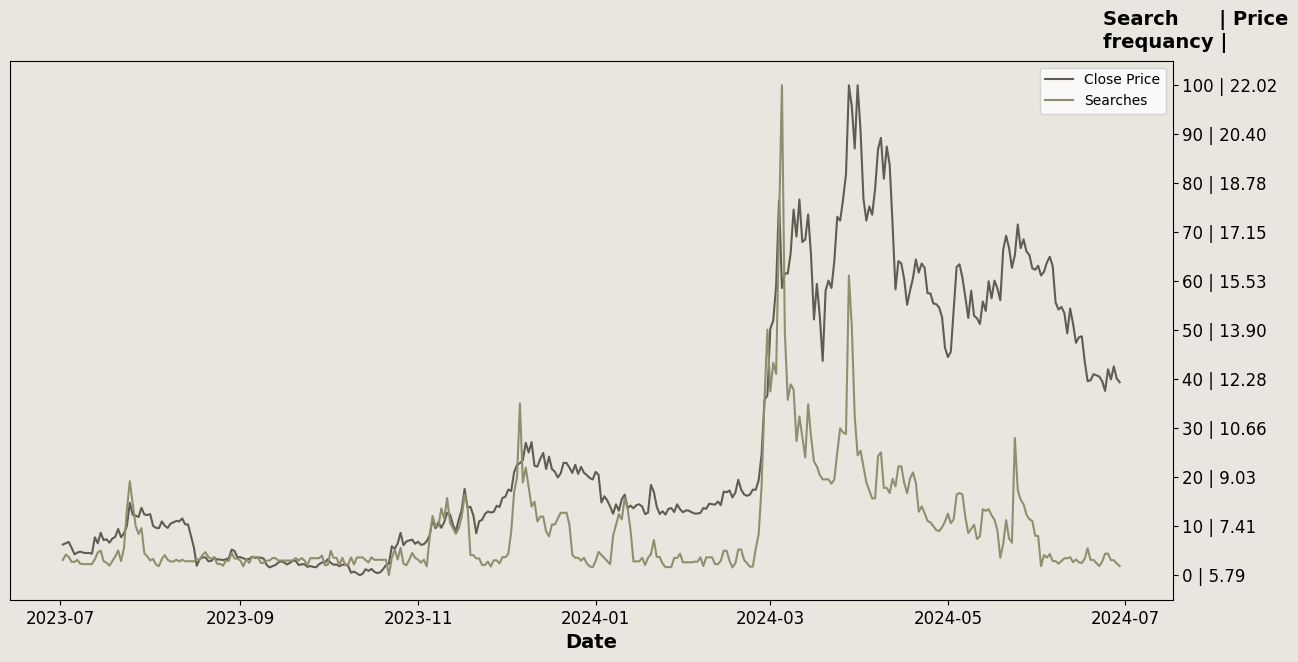

In [84]:
wrn.filterwarnings('ignore')

cutoff = '2023-07-01'

doge = getNormalizedData('Dogecoin', 'DOGE', start = start, end = end, do_double = True)

doge['Date'] = pd.to_datetime(doge['Date'])

dogeTest = doge[doge['Date'] > pd.to_datetime(cutoff)]

min_price_test = dogeTest.Close.min()
max_price_test = dogeTest.Close.max()

# normalizing the close price of doge
dogeTest['Normalized_Close'] = 100 * (dogeTest.Close - min_price_test) / (max_price_test - min_price_test)
dogeTest['reNormalized_Searches'] = 100 * (dogeTest.Normalized_Searches - dogeTest.Normalized_Searches.min()) / (dogeTest.Normalized_Searches.max() - dogeTest.Normalized_Searches.min())

N_y_ticks = 11
test_y_ticks = np.linspace(min_price_test, max_price_test, N_y_ticks)
test_y_ticks_labels = [f'{i * 10} | {y * 100:.2f}' for i, y in enumerate(test_y_ticks)]

# plotting the close and the normalized searches for doge where they have a similar scale
plt.figure(figsize=(15, 7))
plt.plot(dogeTest.Date, dogeTest.Normalized_Close, label='Close Price', color='#615C51')
plt.plot(dogeTest.Date, dogeTest.reNormalized_Searches, label='Searches', color='#918E6F')
# plt.title('Close Price and Searches (in frequrncy) for Dogecoin', pad=20, size=15)
plt.xlabel('Date', fontweight = 'bold', fontsize = 14)
plt.xticks(fontsize = 12)
plt.text(0.94, 111, 'Search      | Price\nfrequancy |', transform = plt.gca().get_yaxis_transform(), ha='left', va = 'center', fontweight = 'bold', fontsize = 14)
plt.yticks([i * 10 for i in range(N_y_ticks)], test_y_ticks_labels, fontsize = 12)
plt.gca().yaxis.tick_right()
plt.legend()
plt.gca().set_facecolor('#E9E6DF')
plt.gcf().set_facecolor('#E9E6DF')
plt.show()

# what from now

- present results in presentation
- discuss results over the complete strategy and by coin (by coin only total return/annual return)
- add to presentation methodology data aquisition and cleaning in bullets
- add to presentation methodology for backtesting in bullets

## Examples for checks code

In [ ]:
# see data validity checks of a certain stock
stock_name = 'Bitcoin' # change to any stock name that is in the list at the top
stock_ticker = 'BTC' # change to the corresponding ticker of the stock

getNormalizedData(stock_name, stock_ticker, 
                  start = start, end = end, 
                  do_double = True, verbose = True)

# see the granger causality test results of a certain stock
df = getNormalizedData(stock_name, stock_ticker, start = start, end = end, do_double = True)

grangercausalitytests(df[['log_returns', 'log_searches']], 
                      maxlag = max_lags, 
                      verbose = True)

# Previously used chunks

In [ ]:
# Calculate correlations for each category
volt_del_corr_general = [trend_corr(stock)[0] for stock in general_stocks]
volt_del_corr_tech = [trend_corr(stock)[0] for stock in tech_stocks]
volt_del_corr_finance = [trend_corr(stock)[0] for stock in finance_stocks]
volt_del_corr_crypto = [trend_corr(crypto)[0] for crypto in decentralized_currencies]

# Combine the results
volt_del_corr = volt_del_corr_general + volt_del_corr_tech + volt_del_corr_finance + volt_del_corr_crypto

# Create labels for the scatter plot
labels = general_stocks + tech_stocks + finance_stocks + decentralized_currencies

Trend Data for ['Shiba Inu'] retrieved successfully.
Stock Data for SHIB-USD retrieved successfully.


In [ ]:
# Plot the scatter plot
plt.figure(figsize=(16, 8))
plt.scatter(range(len(general_stocks)), volt_del_corr_general, color = color_map['general'], label = 'General Stocks')
for i in range(len(general_stocks)):
    plt.axvline(x = i, color = color_map['general'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks), len(general_stocks) + len(tech_stocks)), volt_del_corr_tech, color = color_map['tech'], label = 'Tech Stocks')
for i in range(len(general_stocks), len(general_stocks) + len(tech_stocks)):
    plt.axvline(x = i, color = color_map['tech'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)), volt_del_corr_finance, color = color_map['finance'], label = 'Finance Stocks')
for i in range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)):
    plt.axvline(x = i, color = color_map['finance'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)), volt_del_corr_crypto, color = color_map['crypto'], label = 'Decentralized Currencies')
for i in range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)):
    plt.axvline(x = i, color = color_map['crypto'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.axhline(y = 0, color = 'black', linestyle = '--')  # Add a horizontal line at y = 0
plt.xlabel('Assets')
plt.ylabel('Correlation with 7-Day Delayed Trend')
plt.title('Correlation of Close Price and 7-Day Delayed Trend')
legend = plt.legend()
legend.get_frame().set_alpha(0.3)
plt.xticks(range(len(labels)), labels, rotation = 60)
plt.tight_layout(pad = 2)
plt.savefig('Correlation_Scatter_Plot.png')
plt.show()

# Print the correlation values and their mean
print(volt_del_corr, np.mean(volt_del_corr))

In [ ]:
# Plot for each stock and decentralized currency
for stock in general_stocks + tech_stocks + finance_stocks + decentralized_currencies:
    plot_stock_data(stock, download = True)